# Imports

In [1]:
import numpy as np
import pandas as pd
import mdtraj as md
import encodermap as em
import matplotlib as mpl
import matplotlib.pyplot as plt
import json

from IPython.core.display import display, HTML

import sys, os, re
from glob import glob

import xplor

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

/home/kevin/projects/encoder_map_private/encodermap/loading/features.py:36: UserWarning: Features need Unittests
  warnings.warn("Features need Unittests")


Redefining os.path.isfile to work with tmp_stringio.pdb
Redefining open() to work with tmp_stringio.pdb


## Pandas print options

In [2]:
pd.set_option("display.max_rows", 5)

# Module wide variables

In [29]:
OVERWRITE = False
UBQ_SITES = ['k6', 'k29', 'k33']
AA_DF_FILE = '/home/kevin/git/xplor_functions/xplor/data/all_frames_sPRE_sim.csv'
AA_DF_FILE_HDF5 = '/home/kevin/git/xplor_functions/xplor/data/all_frames_sPRE_sim.h5'

# functions
remove_normalized = lambda x: ' '.join(x.split()[1:])

# residues of 1UBQ
from xplor.proteins.proteins import get_column_names_from_pdb
RESIDUES = get_column_names_from_pdb(return_residues=True)
print(RESIDUES)

['MET1' 'GLN2' 'ILE3' 'PHE4' 'VAL5' 'LYS6' 'THR7' 'LEU8' 'THR9' 'GLY10'
 'LYS11' 'THR12' 'ILE13' 'THR14' 'LEU15' 'GLU16' 'VAL17' 'GLU18' 'PRO19'
 'SER20' 'ASP21' 'THR22' 'ILE23' 'GLU24' 'ASN25' 'VAL26' 'LYS27' 'ALA28'
 'LYS29' 'ILE30' 'GLN31' 'ASP32' 'LYS33' 'GLU34' 'GLY35' 'ILE36' 'PRO37'
 'PRO38' 'ASP39' 'GLN40' 'GLN41' 'ARG42' 'LEU43' 'ILE44' 'PHE45' 'ALA46'
 'GLY47' 'LYS48' 'GLN49' 'LEU50' 'GLU51' 'ASP52' 'GLY53' 'ARG54' 'THR55'
 'LEU56' 'SER57' 'ASP58' 'TYR59' 'ASN60' 'ILE61' 'GLN62' 'LYS63' 'GLU64'
 'SER65' 'THR66' 'LEU67' 'HIS68' 'LEU69' 'VAL70' 'LEU71' 'ARG72' 'LEU73'
 'ARG74' 'GLY75' 'GLY76']


# Load the data from Tobi

In [4]:
exp_values = xplor.functions.parse_input_files.get_observed_df(UBQ_SITES)
fast_exchangers = xplor.functions.parse_input_files.get_fast_exchangers(UBQ_SITES)
fast_exchangers

,k6,k29,k33
proximal MET1 fast_exchange,False,False,False
proximal GLN2 fast_exchange,True,False,False
...,...,...,...
distal GLY75 fast_exchange,False,False,False
distal GLY76 fast_exchange,False,False,False


rename the index of the fast exchangers to fit the rest

In [5]:
fast_exchangers.index = fast_exchangers.index.str.replace('fast_exchange', 'sPRE')
fast_exchangers

,k6,k29,k33
proximal MET1 sPRE,False,False,False
proximal GLN2 sPRE,True,False,False
...,...,...,...
distal GLY75 sPRE,False,False,False
distal GLY76 sPRE,False,False,False


Filter the sPRE values from the exp values

In [6]:
exp_values = exp_values.filter(like='sPRE', axis=0)
exp_values

,k6,k29,k33
proximal MET1 sPRE,0.000000,0.000000,0.000000
proximal GLN2 sPRE,4.024789,6.029261,5.775995
...,...,...,...
distal GLY75 sPRE,0.000000,0.000000,0.000000
distal GLY76 sPRE,0.000000,0.000000,0.000000


In [7]:
not_exp_values = exp_values == 0
exclude_data = fast_exchangers | not_exp_values

# Load the simulated data

In [31]:
# aa_df.to_csv(AA_DF_FILE)
aa_df.to_hdf(AA_DF_FILE_HDF5, 'aa_df')

In [33]:
if 'sim_values' not in globals():
    sim_values = pd.read_csv("/home/kevin/projects/tobias_schneider/values_from_every_frame/new_psol_all/2022-01-04T01:56:06+01:00_new_psol_all_frames.csv")
    
# copy already loaded df
if not os.path.isfile(AA_DF_FILE_HDF5) or OVERWRITE:
    aa_df = sim_values.copy()

    # remove Unnamed columns
    aa_df = aa_df.loc[:, ~aa_df.columns.str.contains('^Unnamed')]

    # make ubq_site lower
    aa_df['ubq_site'] = aa_df['ubq_site'].str.lower()

    # define a basename frame multiindex
    aa_df = aa_df.set_index(['traj_file', 'frame'])
    
    # define multiindex for columns
    column_multi = []

    for column in aa_df.columns:
        add = []
        if 'sPRE' in column:
            add.append('sPRE')
        elif '15N_relax_600' in column:
            add.append('15N_relax_600')
        elif '15N_relax_800' in column:
            add.append('15N_relax_800')
        elif 'RWMD' in column:
            add.append('RWMD')
        elif column == 'x' or column =='y':
            add.append("Encodermap")
        else:
            add.append('data')

        if 'distal' in column or 'dist' in column:
            add.append('distal')
        elif 'proximal' in column or 'prox' in column:
            add.append('proximal')
        else:
            add.append('')

        add.append(column)

        column_multi.append(tuple(add))

    aa_df.columns = pd.MultiIndex.from_tuples(column_multi)
else:
    aa_df = pd.read_hdf(AA_DF_FILE_HDF5, 'aa_df')
aa_df

data  \
                                                                                                              
                                                                                                   top_file   
traj_file                                          frame                                                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   1      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
..                                                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   
                                                   4638   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   

                                                                   \
                                                                    
                                                             time   
traj_file                                          frame            
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0          0.0   
                                                   1         10.0   
..                                                            ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   46370.0   
                                                   4638   46380.0   

                                                                       sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.959840   
                                                   1               0.789034   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.693595   
                                                   4638            0.897162   

                                                                             \
                                                                              
                                                         proximal GLN2 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.569783   
                                                   1               0.590163   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.445207   
                                                   4638            0.435836   

                                                                             \
                                                                              
                                                         proximal ILE3 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.183758   
                                                   1               0.188011   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.154382   
                                                   4638            0.144380   

                                                                             \
                                                                              
                                                         proximal PHE4 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2

## Add the RWMD, the xy values and the cluster id

In [13]:
from xplor.functions.functions import Capturing
from xplor.functions.custom_gromacstopfile import CustomGromacsTopFile
import warnings
import dateutil
from scipy.spatial.distance import cdist

def has_no_key_or_any_nan(df, key):
    if not key in df:
        return True
    else:
        if df[key].isna().any(None):
            return True
    return False

def ckpt_step(file):
    file = os.path.basename(file).split('.')[0].split('_')[-1]
    try:
        return int(file)
    except ValueError as e1:
        try:
            time = dateutil.parser.isoparse(file)
        except Exception as e2:
            raise e2 from e1
    return 0

key = 'RWMD'
if has_no_key_or_any_nan(aa_df, key) or OVERWRITE:
    # set labels
    rwmd_labels = []
    for lbl in [f'proximal {_} RWMD' for _ in RESIDUES]:
        rwmd_labels.append(('RWMD', 'proximal', lbl))
    for lbl in [f'distal {_} RWMD' for _ in RESIDUES]:
        rwmd_labels.append(('RWMD', 'distal', lbl))
    rwmd_labels = pd.MultiIndex.from_tuples(rwmd_labels)
    
    if not key in aa_df:
        aa_df[rwmd_labels] = np.nan
    
    # iterate over trajs
    for i, (traj_file, sub_df) in enumerate(aa_df.groupby(level=0)):
        if i % 20 == 0:
            print(f"At {i}: {traj_file}")
        # define ubq
        ubq_site = aa_df.loc[traj_file, ('data', '', 'ubq_site')].unique()
        assert len(ubq_site) == 1, print(ubq_site)
        ubq_site = ubq_site[0]
        
        # check again to reduce load times
        if not has_no_key_or_any_nan(aa_df.loc[traj_file], key) and not OVERWRITE:
            continue
            
        # load traj
        top_file = sub_df.iloc[0][('data', '', 'top_file')]
        traj = md.load(traj_file, top=top_file)
        with Capturing() as output:
            top_aa = CustomGromacsTopFile(f'/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_{ubq_site.upper()}/system.top',
                                          includeDir='/home/andrejb/Software/gmx_forcefields')
        top = md.Topology.from_openmm(top_aa.topology)
        traj.topology = top

        # define CAs
        CAs_prox = top.select('name CA and resid >= 76')
        CAs_dist = top.select('name CA and resid < 76')
        assert CAs_prox.shape == CAs_dist.shape

        # calc RWMD
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            _ = traj.xyz
            dists_0_1 = np.vstack([np.min(cdist(_[i, CAs_prox], _[i, CAs_dist]), axis=1) for i in range(len(_))])
            dists_1_0 = np.vstack([np.min(cdist(_[i, CAs_dist], _[i, CAs_prox]), axis=1) for i in range(len(_))])

        # stack
        dists = np.hstack([dists_0_1, dists_1_0])
        assert dists.shape[0] == traj.n_frames

        # only select frames that are in aa_df
        ind = sub_df.index.get_level_values('frame')
        dists = dists[ind]

        # append
        assert len(aa_df.loc[traj_file]) == len(dists)
        aa_df.loc[traj_file, rwmd_labels] = dists
else:
    print(f"aa_df is full of RMWD values. Set OVERWRITE to True to calculate again.")
    
key = 'Encodermap'
if has_no_key_or_any_nan(aa_df, key) or OVERWRITE:
    # set labels
    sketchmap_labels = pd.MultiIndex.from_tuples([('Encodermap', '', 'x'), ('Encodermap', '', 'y')])
    encodermaps = {}
    
    if not key in aa_df:
        aa_df[sketchmap_labels] = np.nan
        
    for i, (traj_file, sub_df) in enumerate(aa_df.groupby(level=0)):
        if i % 20 == 0:
            print(f"At {i}: {traj_file}")
        # define ubq
        ubq_site = aa_df.loc[traj_file, ('data', '', 'ubq_site')].unique()
        assert len(ubq_site) == 1, print(ubq_site)
        ubq_site = ubq_site[0]
        
        # check again to reduce load times
        if not has_no_key_or_any_nan(aa_df.loc[traj_file], key) and not OVERWRITE:
            continue
            
        # find the encodermap checkpoint
        if ubq_site not in encodermaps:
            train_path = f'/mnt/data/kevin/xplor_analysis_files/runs/{ubq_site}/production_run_tf2/saved_model_*encoder'
            checkpoints = glob(train_path)
            checkpoint = list(sorted(checkpoints, key=ckpt_step))[-1].replace('model_encoder', '*')
            encodermaps[ubq_site] = em.EncoderMap.from_checkpoint(checkpoint)
            
        # get lowd
        lowd = encodermaps[ubq_site].encode(aa_df.loc[traj_file]['RWMD'].values)
        
        # set data
        assert len(aa_df.loc[traj_file]) == len(lowd)
        aa_df.loc[traj_file, sketchmap_labels] = lowd
    else:
        del encodermaps
        assert not aa_df[sketchmap_labels].isna().any(None)
else:
    print(f"aa_df is full of xy values. Set OVERWRITE to True to calculate again.")
        
key = ('data', '', 'cluster_id')
if has_no_key_or_any_nan(aa_df, key) or OVERWRITE:
    # load the cluster membership from existing dataframes
    tmp_df = pd.read_csv('/mnt/data/kevin/xplor_analysis_files/lowd_and_xplor_df.csv.back',
                         usecols=['traj_file', 'frame', 'cluster_membership'])
    tmp_df = tmp_df.set_index(['traj_file', 'frame'])
    tmp_df.columns = pd.MultiIndex.from_tuples([('data', '', 'cluster_id')])
    test = aa_df.merge(tmp_df, left_index=True, right_index=True, how='outer')
    test = test.reindex(index=aa_df.index)
    test2 = tmp_df.reindex(index=aa_df.index)
    assert np.array_equal(test[('data', '', 'cluster_id')].values, test2[('data', '', 'cluster_id')].values)
    del tmp_df
    aa_df = test
    assert not aa_df[key].isna().any(None)
else:
    print(f"aa_df is full of cluster_id values. Set OVERWRITE to True to calculate again.")
        
    
aa_df

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/pandas/core/frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


At 0: /home/andrejb/Research/SIMS/2017_02_14_G_2ub_k33_01_01/traj_nojump.xtc
At 20: /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k29_02_03/traj_nojump.xtc
At 40: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_k29_1/traj_nojump.xtc
At 60: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k29_2/traj_nojump.xtc
At 80: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k33_10/traj_nojump.xtc
At 100: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k33_29/traj_nojump.xtc
At 120: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k6_2/traj_nojump.xtc
At 140: /home/andrejb/Research/SIMS/2017_09_26_GfM_SMmin_k6_3/traj_nojump.xtc
At 160: /home/andrejb/Research/SIMS/2017_09_26_GfM_SMmin_rnd_k33_39/traj_nojump.xtc
At 180: /home/andrejb/Research/SIMS/2017_11_16_2ub_NaCl_k33_02_04/traj_nojump.xtc


/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

At 200: /home/kevin/projects/molsim/diUbi_aa/K33_80/traj_nojump.xtc


/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

At 0: /home/andrejb/Research/SIMS/2017_02_14_G_2ub_k33_01_01/traj_nojump.xtc


2022-01-31 13:21:35.749655: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


rebuilding Model with input_dim = 152
rebuilding Model with input_dim = 152
At 20: /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k29_02_03/traj_nojump.xtc
rebuilding Model with input_dim = 152
At 40: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_k29_1/traj_nojump.xtc
At 60: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k29_2/traj_nojump.xtc
At 80: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k33_10/traj_nojump.xtc
At 100: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k33_29/traj_nojump.xtc
At 120: /home/andrejb/Research/SIMS/2017_06_28_GfM_SMmin_rnd_k6_2/traj_nojump.xtc
At 140: /home/andrejb/Research/SIMS/2017_09_26_GfM_SMmin_k6_3/traj_nojump.xtc
At 160: /home/andrejb/Research/SIMS/2017_09_26_GfM_SMmin_rnd_k33_39/traj_nojump.xtc
At 180: /home/andrejb/Research/SIMS/2017_11_16_2ub_NaCl_k33_02_04/traj_nojump.xtc
At 200: /home/kevin/projects/molsim/diUbi_aa/K33_80/traj_nojump.xtc


data  \
                                                                                                              
                                                                                                   top_file   
traj_file                                          frame                                                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   1      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
..                                                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   
                                                   4638   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   

                                                                   \
                                                                    
                                                             time   
traj_file                                          frame            
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0          0.0   
                                                   1         10.0   
..                                                            ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   46370.0   
                                                   4638   46380.0   

                                                                       sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.959840   
                                                   1               0.789034   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.693595   
                                                   4638            0.897162   

                                                                             \
                                                                              
                                                         proximal GLN2 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.569783   
                                                   1               0.590163   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.445207   
                                                   4638            0.435836   

                                                                             \
                                                                              
                                                         proximal ILE3 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.183758   
                                                   1               0.188011   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.154382   
                                                   4638            0.144380   

                                                                             \
                                                                              
                                                         proximal PHE4 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2

## Add the remaining data

- cluster_centroids
- 20_structures_for_plotting
- internal_rmsd
- aa_percent
- ensemble_percent
- geom_centroid
- rmsd_centroid

In [14]:
if not 'geom_centroid' in aa_df or OVERWRITE:
    tmp_df = pd.concat([pd.read_csv(f'/mnt/data/kevin/xplor_analysis_files/sub_df_for_saving_{ubq_site}.csv.back_before_new_psol',
                                    usecols=['traj_file', 'frame', '20_selected_for_rendering',
                                             'ensemble_percent', 'geom_centroid', 'internal_rmsd',
                                              'aa_percent', 'rmsd_centroid']) for ubq_site in UBQ_SITES])
    tmp_df = tmp_df.set_index(['traj_file', 'frame'])
    tmp_df.columns = pd.MultiIndex.from_tuples([('data', '', i) for i in tmp_df.columns])
    test = aa_df.merge(tmp_df, left_index=True, right_index=True, how='outer')
    test = test.reindex(index=aa_df.index)
    aa_df = test
else:
    print(f"aa_df is full of cluster_id values. Set OVERWRITE to True to calculate again.")

## Add the count_id

In [15]:
def counting_func(df):
    sub_dfs = []
    for ubq_site, sub_df in df.groupby(level=0):
        sub_df.loc[sub_df.index] = np.array(range(len(sub_df))) - 1
        sub_dfs.append(sub_df)
    sub_dfs = pd.concat(sub_dfs)
    return sub_dfs

with pd.option_context("display.max_rows", None):
    counts = (aa_df
              .groupby([('data', '', 'ubq_site'), ('data', '', 'cluster_id')])
              .size()
              .to_frame()
              .rename(columns={0: 'count'}))
    counts = counts.sort_values([('data', '', 'ubq_site'), 'count'], ascending=False)
    counts['count_id'] = counts.apply(counting_func, axis='rows')
    counts = counts['count_id'].to_frame()
    counts.columns = pd.MultiIndex.from_tuples([('data', '', 'count_id')])
    counts = counts.reset_index()
    # print(counts)

aa_df = aa_df.reset_index().merge(counts, how='left').set_index(['traj_file', 'frame'])

In [18]:
with pd.option_context("display.max_rows", 100):
    display(HTML(aa_df.iloc[np.random.choice(range(len(aa_df)), 100)][[('data', '', 'ubq_site'), ('data', '', 'cluster_id'), ('data', '', 'count_id')]]._repr_html_()))

## Redo the normalization

In [19]:
aa_df[('data', '', 'ubq_site')]

traj_file                                                              frame
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc  0         k6
                                                                       1         k6
                                                                               ... 
/home/kevin/projects/molsim/diUbi_aa/K33_160/traj_nojump.xtc           4637     k33
                                                                       4638     k33
Name: (data, , ubq_site), Length: 411121, dtype: object

In [20]:
idx = pd.MultiIndex.from_tuples([('sPRE', *i) for i in aa_df['sPRE'].columns.tolist()] + [('data', '', 'ubq_site')])
group = aa_df[idx].groupby(('data', '', 'ubq_site'))
variances = group.var()
means = group.mean()

variances = variances.droplevel([0, 1], 'columns')
means = means.droplevel([0, 1], 'columns')

prox_var = variances[variances.columns[variances.columns.str.contains('proximal')]]
dist_var = variances[variances.columns[variances.columns.str.contains('distal')]]

prox_mean = means[means.columns[means.columns.str.contains('proximal')]]
dist_mean = means[means.columns[means.columns.str.contains('distal')]]

In [21]:
def drop_all_similar_cols(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    if cols_to_drop.empty:
        return df
    else:
        return prox.drop(cols_to_drop)
    
def get_normalization_factors(var, mean, exp):
    factors_out = {}
    for ubq_site in exp.columns:
        series = exp[ubq_site]
        ind = series.index[series != 0].intersection(var.columns)
        values = var.loc[ubq_site, ind]
        nsmallest = values.nsmallest(10)
        factors = exp.loc[nsmallest.index, ubq_site] / mean.loc[ubq_site, nsmallest.index]
        factor = factors.mean()
        factors_out[ubq_site] = factor
    return factors_out
    
prox_factors = get_normalization_factors(drop_all_similar_cols(prox_var), prox_mean, exp_values)
dist_factors = get_normalization_factors(drop_all_similar_cols(dist_var), dist_mean, exp_values)
    
factors = {'proximal': prox_factors, 'distal': dist_factors}

In [22]:
factors = pd.merge(pd.Series(factors['proximal'], name='proximal').to_frame(),
                   pd.Series(factors['distal'], name='distal').to_frame(),
                   left_index=True, right_index=True)
factors.index.name = 'ubq_site'
factors

,proximal,distal
ubq_site,,
k6,17.766674,17.357122
k29,25.881481,14.282657
k33,35.584115,28.473156


In [23]:
# normalized_prox_columns = aa_df.columns[aa_df.columns.str.contains('proximal') & aa_df.columns.str.contains('sPRE')].map(lambda x: 'normalized ' + x)
# normalized_dist_columns = aa_df.columns[aa_df.columns.str.contains('distal') & aa_df.columns.str.contains('sPRE')].map(lambda x: 'normalized ' + x)
normalized_prox_columns = [('normalized sPRE', 'proximal', 'normalized ' + i) for i in aa_df[('sPRE', 'proximal')].columns]
normalized_prox_columns = pd.MultiIndex.from_tuples(normalized_prox_columns)

normalized_dist_columns = [('normalized sPRE', 'distal', 'normalized ' + i) for i in aa_df[('sPRE', 'distal')].columns]
normalized_dist_columns = pd.MultiIndex.from_tuples(normalized_dist_columns)

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [24]:
aa_df.loc[:, (aa_df.columns.get_level_values(2) == 'ubq_site') | (aa_df.columns.get_level_values(2).str.contains('sPRE'))]

sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.959840   
                                                   1               0.789034   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.693595   
                                                   4638            0.897162   

                                                                             \
                                                                              
                                                         proximal GLN2 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.569783   
                                                   1               0.590163   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.445207   
                                                   4638            0.435836   

                                                                             \
                                                                              
                                                         proximal ILE3 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.183758   
                                                   1               0.188011   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.154382   
                                                   4638            0.144380   

                                                                             \
                                                                              
                                                         proximal PHE4 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.175383   
                                                   1               0.197491   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.212336   
                                                   4638            0.196656   

                                                                             \
                                                                              
                                                         proximal VAL5 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.141182   
                                                   1               0.157674   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.121226   
                                                   4638            0.137530   

                                                                             \
                                                                              
                                                         proximal LYS6 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.124143   
                                                   1               0.124157   
..                                   

In [25]:
tmp = aa_df.loc[:, (aa_df.columns.get_level_values(2) == 'ubq_site') | (aa_df.columns.get_level_values(2).str.contains('sPRE'))]
tmp.index.name = 'ubq_site'
def func(args):
    if any('sPRE' in a for a in args):
        return ('normalized ' + args[0], args[1], 'normalized ' + args[2])
    else:
        return args
    
tmp.columns = tmp.columns.map(func)


for ubq_site, row in factors.iterrows():
    for position, value in row.iteritems():
        print(ubq_site, value)
        tmp.loc[tmp[('data', '', 'ubq_site')] == ubq_site, tmp.columns.get_level_values(2).str.contains(position)] *= value
tmp.drop('ubq_site', level=2, axis='columns', inplace=True)

k6 17.76667407151073


/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


k6 17.357121676238766
k29 25.88148119805224
k29 14.28265652369432
k33 35.58411483613997
k33 28.47315551397265


/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
aa_df

data  \
                                                                                                              
                                                                                                   top_file   
traj_file                                          frame                                                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   1      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
..                                                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   
                                                   4638   /home/kevin/projects/molsim/diUbi_aa/K33_160/i...   

                                                                   \
                                                                    
                                                             time   
traj_file                                          frame            
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0          0.0   
                                                   1         10.0   
..                                                            ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637   46370.0   
                                                   4638   46380.0   

                                                                       sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.959840   
                                                   1               0.789034   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.693595   
                                                   4638            0.897162   

                                                                             \
                                                                              
                                                         proximal GLN2 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.569783   
                                                   1               0.590163   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.445207   
                                                   4638            0.435836   

                                                                             \
                                                                              
                                                         proximal ILE3 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6... 0               0.183758   
                                                   1               0.188011   
..                                                                      ...   
/home/kevin/projects/molsim/diUbi_aa/K33_160/tr... 4637            0.154382   
                                                   4638            0.144380   

                                                                             \
                                                                              
                                                         proximal PHE4 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2

In [27]:
aa_df = aa_df.merge(tmp, how='outer', on=['traj_file', 'frame'])

### verify the normalization

In [28]:
for ubq_site, row in factors.iterrows():
    for position, value in row.iteritems():
        norm = test.loc[test[('data', '', 'ubq_site')] == ubq_site, test.columns.get_level_values(2).str.contains('normalized ' + position)]
        norm.columns = norm.columns.droplevel([0, 1])
        norm.columns = norm.columns.map(remove_normalized)
        
        non_norm = test.loc[test[('data', '', 'ubq_site')] == ubq_site, (test.columns.get_level_values(2).str.contains(position)) & (test.columns.get_level_values(0) == 'sPRE')]
        non_norm.columns = non_norm.columns.droplevel([0, 1])
        factor = np.unique((norm / non_norm).round(8))
        factor = factor[np.logical_not(np.isnan(factor))]
        assert len(factor) == 1
        assert np.isclose(factor, value, atol=1e-8)
print("Normalization successful")

AssertionError: 

## Redo the mean_abs_diff

In [92]:
pd.MultiIndex.from_tuples(tuples=[('data', '', 'mean_abs_diff')])

MultiIndex([('data', '', 'mean_abs_diff')],
           )

In [238]:
def get_mean_abs_diff_vectorized(sub_df, exclude=True):
    sim = sub_df['normalized sPRE']
    sim.columns = sim.columns.droplevel(0).map(remove_normalized)
    
    # exp
    ubq_site = sub_df[('data', '', 'ubq_site')].unique()
    assert len(ubq_site) == 1
    ubq_site = ubq_site[0]
    exclusions = exclude_data[ubq_site]
    if any(['normalized' in i for i in exclusions.index]):
        print("Removing normalized from exclusions")
        exclusions.index = exclusions.index.map(remove_normalized)
    exp = exp_values[ubq_site]
    if any(['normalized' in i for i in exp.index]):
        print("Removing normalized from experimental")
        exp.index = exp.index.map(remove_normalized)
        
        
    if exclude:
        for i, j in zip(exclusions.index.tolist(), sim.columns.tolist()):
            if i != j:
                print(i, j)
        sim = sim.loc[:, ~ exclusions]
        exp = exp[~ exclusions]
        
    mean_abs_diff = (sim - exp).abs().mean(axis='columns')
    if ubq_site == 'k6':
        print(mean_abs_diff['/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_nojump.xtc', 6])
    
    return mean_abs_diff

def get_mean_abs_diff_iteration(df):
    mean_abs_diff = []
    for i, row in df.iterrows():
        print(i, row)
        ubq_site = row[('data', '', 'ubq_site')]
        exp = exp_values
        break

test = aa_df.groupby([('data', '', 'ubq_site')]).apply(get_mean_abs_diff_vectorized)
test.name = 'mean_abs_diff'
test = test.to_frame()
test.index = test.index.droplevel(0)
# test.columns = pd.MultiIndex.from_tuples(tuples=[('data', '', 'mean_abs_diff')])

if ('data', '', 'mean_abs_diff') in aa_df.columns:
    aa_df = aa_df.drop(('data', '', 'mean_abs_diff'), 'columns')
aa_df[('data', '', 'mean_abs_diff')] = test

# test2 = get_mean_abs_diff_iteration(aa_df)

2.026411394628857


In [241]:
aa_df['data'].columns

MultiIndex([('',                  'top_file'),
            ('',                      'time'),
            ('',                  'basename'),
            ('',                  'ubq_site'),
            ('',                'isopeptide'),
            ('',                'cluster_id'),
            ('', '20_selected_for_rendering'),
            ('',                'aa_percent'),
            ('',          'ensemble_percent'),
            ('',             'geom_centroid'),
            ('',             'internal_rmsd'),
            ('',             'rmsd_centroid'),
            ('',                  'count_id'),
            ('',             'mean_abs_diff')],
           )

## Redo the Optimization of the linear combination

Import scipy df

In [40]:
from typing import Callable
from scipy.optimize import minimize, NonlinearConstraint, Bounds, nnls

Define bounds, constraints and objective function

In [41]:
constraint = NonlinearConstraint(np.sum, 1., 1.)
bounds = Bounds(0, 1)

Remove -1 count_ids from df

In [42]:
only_clusters_aa_df = aa_df[aa_df[('data', '', 'count_id')] > -1]

Groupby ubq_site and count_id and get means of normalized sPRE

In [43]:
grouped = only_clusters_aa_df.groupby([('data', '', 'ubq_site'), ('data', '', 'count_id')]).mean()['normalized sPRE']

Rename columns in exclude and experimental dataframe

In [44]:
exclude_data_col_renamed_normalized = exclude_data.copy()
exclude_data_col_renamed_normalized.index = exclude_data_col_renamed_normalized.index.map(lambda x: 'normalized ' + x)
exclude_data_col_renamed_normalized

,k6,k29,k33
normalized proximal MET1 sPRE,True,True,True
normalized proximal GLN2 sPRE,True,False,False
...,...,...,...
normalized distal GLY75 sPRE,True,True,True
normalized distal GLY76 sPRE,True,True,True


In [45]:
exp_values_col_renamed_normalized = exp_values.copy()
exp_values_col_renamed_normalized.index = exp_values_col_renamed_normalized.index.map(lambda x: 'normalized ' + x)
exp_values_col_renamed_normalized

,k6,k29,k33
normalized proximal MET1 sPRE,0.000000,0.000000,0.000000
normalized proximal GLN2 sPRE,4.024789,6.029261,5.775995
...,...,...,...
normalized distal GLY75 sPRE,0.000000,0.000000,0.000000
normalized distal GLY76 sPRE,0.000000,0.000000,0.000000


Iterate over ubq_sites

In [46]:
def get_objective_function(cluster_means: np.ndarray, observed_values: np.ndarray) -> Callable:
    def obj_fun(x: np.ndarray) -> float:
        return np.linalg.norm(np.sum(x * cluster_means, 1) - observed_values)
    return obj_fun

combination_factors = {}
for ubq_site, means in grouped.groupby([('data', '', 'ubq_site')]):
    # reshape the cluster means
    means = means.droplevel(0, axis='columns').reset_index().drop(columns=[('data', '', 'count_id'), ('data', '', 'ubq_site')])
    
    # get observed values and exclusions
    exp = exp_values_col_renamed_normalized[ubq_site]
    exclude = exclude_data_col_renamed_normalized[ubq_site]
    
    # remove exclusions
    exp = exp[~exclude]
    means = means.loc[:, ~exclude]
    
    # initial guess
    initial_guess = nnls(means.T, exp)[0]
    
    # optimize
    res = minimize(get_objective_function(means.T, exp), initial_guess,
                   constraints=[constraint], bounds=bounds)
    
    combination_factors[ubq_site] = res.x
    
    print(ubq_site, np.round(res.x, 2), np.sum(res.x), '\n')

k29 [0.   0.05 0.   0.   0.01 0.   0.33 0.   0.   0.   0.   0.41 0.   0.
 0.   0.   0.   0.19] 1.0000000000000704 

k33 [0.   0.   0.   0.   0.4  0.   0.   0.   0.   0.06 0.   0.   0.16 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.37] 1.0000000000000702 

k6 [0.21 0.   0.2  0.   0.   0.59 0.   0.   0.   0.   0.   0.   0.  ] 1.0000000000000004 



## Redo the optimization with only the 3 largest clusters

In [61]:
only_clusters_aa_df_only_3 = aa_df[(aa_df[('data', '', 'count_id')] > -1) & (aa_df[('data', '', 'count_id')] < 4)]
grouped_only_3 = only_clusters_aa_df_only_3.groupby([('data', '', 'ubq_site'), ('data', '', 'count_id')]).mean()['normalized sPRE']

combination_factors_only_3 = {}
for ubq_site, means in grouped_only_3.groupby([('data', '', 'ubq_site')]):
    # reshape the cluster means
    means = means.droplevel(0, axis='columns').reset_index().drop(columns=[('data', '', 'count_id'), ('data', '', 'ubq_site')])
    
    # get observed values and exclusions
    exp = exp_values_col_renamed_normalized[ubq_site]
    exclude = exclude_data_col_renamed_normalized[ubq_site]
    
    # remove exclusions
    exp = exp[~exclude]
    means = means.loc[:, ~exclude]
    
    # initial guess
    initial_guess = nnls(means.T, exp)[0]
    
    # optimize
    res = minimize(get_objective_function(means.T, exp), initial_guess,
                   constraints=[constraint], bounds=bounds)
    
    combination_factors_only_3[ubq_site] = res.x
    
    print(ubq_site, np.round(res.x, 2), np.sum(res.x), '\n')

k29 [0.45 0.3  0.25 0.  ] 1.0 

k33 [0.   0.28 0.46 0.26] 1.0 

k6 [0.66 0.   0.34 0.  ] 1.0000000000000002 



# make some correlation plots

In [47]:
idx = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE][[('data', '', 'mean_abs_diff')]].idxmin()
aa_df.loc[idx]

data  \
                                                                                                              
                                                                                                   top_file   
traj_file                                          frame                                                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6      /home/kevin/projects/molsim/diUbi_aa/K6_0/init...   

                                                                \
                                                                 
                                                          time   
traj_file                                          frame         
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6      60.0   

                                                                       sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.868724   

                                                                             \
                                                                              
                                                         proximal GLN2 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.473412   

                                                                             \
                                                                              
                                                         proximal ILE3 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.158834   

                                                                             \
                                                                              
                                                         proximal PHE4 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.120421   

                                                                             \
                                                                              
                                                         proximal VAL5 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.154737   

                                                                             \
                                                                              
                                                         proximal LYS6 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.161718   

                                                                             \
                                                                              
                                                         proximal THR7 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6                0.19881   

                                                                             \
                                                                              
                                                         proximal LEU8 sPRE   
traj_file                                          frame                      
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_... 6               0.253032   

                                                

In [48]:
def make_correlation(x, y, ax, title, xlabel, ylabel, annotations=False,
                    exclusions=None, return_mad=False):
    if exclusions is not None:
        x = x[~exclusions]
        y = y[~exclusions]
    # norm factor
    get_norm = False
    if x.ndim == 2 and y.ndim == 2:
        get_norm = True
    elif x.ndim == 1 and y.ndim == 1:
        tmp = pd.concat([x, y], axis='columns')
        corr = tmp['exp'].corr(tmp['sim'])
        mad = (tmp['sim'] - tmp['exp']).abs().mean()
        if return_mad:
            return mad
        text = '\n'.join([f'corr = {corr:.2f}', f'MAD = {mad:.2f}'])
        ax.text(0.8, 0.95, s=text, va='center', ha='center', transform=ax.transAxes)
        
        # polyfit
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        ax.plot(x, y, 'o', x, poly1d_fn(x), '--k')
        
    # what to do with x
    if x.ndim == 2:
        x = x.quantile([0.25, 0.5, 0.75])
        x_err = x.loc[[0.25, 0.75]]
        x = x.loc[0.5]
        x_err = pd.DataFrame((x_err.iloc[0] - x, x - x_err.iloc[1]))
    elif x.ndim == 1:
        x_err = None
    else:
        raise Exception(f"Unkown dim {x.ndim} for arg `x`.")
        
    # what to do with y
    if y.ndim == 2:
        y = y.quantile([0.25, 0.5, 0.75])
        y_err = y.loc[[0.25, 0.75]]
        y = y.loc[0.5]
        y_err = pd.DataFrame((y_err.iloc[0] - y, y - y_err.iloc[1]))
    elif y.ndim == 1:
        y_err = None
    else:
        raise Exception(f"Unkown dim {y.ndim} for arg `y`.")
        
    # norm factor
    if get_norm:
        norm_factor = np.unique(np.round((x.values / y.values), 5))
        norm_factor = norm_factor[~ np.isnan(norm_factor)]
        assert len(norm_factor) == 1, print(norm_factor)
        norm_factor = norm_factor[0]
        ax.text(0.8, 0.95, s=f'norm factor = {norm_factor:.2f}', va='center', ha='center', transform=ax.transAxes)
        
    if annotations:
        texts = []
        for name, x_pos, y_pos in zip(x.index, x, y):
            name = name.split()[1]
            texts.append(ax.text(x_pos, y_pos, name))
        adjust_text(texts,
                    arrowprops=dict(arrowstyle="->", color='r', lw=0.5)
                   )
        
    if x_err is None and y_err is None:
        pass
    else:
        ax.errorbar(x, y, x_err.values, y_err.values)
    
    # add some text
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

Why is mean abs diff in aa_df different than in the function?

In [49]:
idx = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE][[('data', '', 'mean_abs_diff')]].idxmin()
row = aa_df.loc[idx]

y = row['normalized sPRE']
y = y.droplevel(0, 'columns')
y.columns = y.columns.map(lambda _: _.replace('normalized ', ''))
y = y.iloc[0]
y.name = 'sim'
x = exp_values[UBQ_SITE]
x.name = 'exp'
mad = make_correlation(x, y, None, 'best fitting structure (smalled MAD)',
                              'experiment', 'simulation',
                              False,
                              exclusions=exclude_data[UBQ_SITE],
                       return_mad=True
                             )

print(mad, '\n', row[('data', '', 'mean_abs_diff')])

2.0264113946288567 
 traj_file                                                  frame
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_nojump.xtc  6        2.026411
Name: (data, , mean_abs_diff), dtype: float64


Plot

<IPython.core.display.Javascript object>


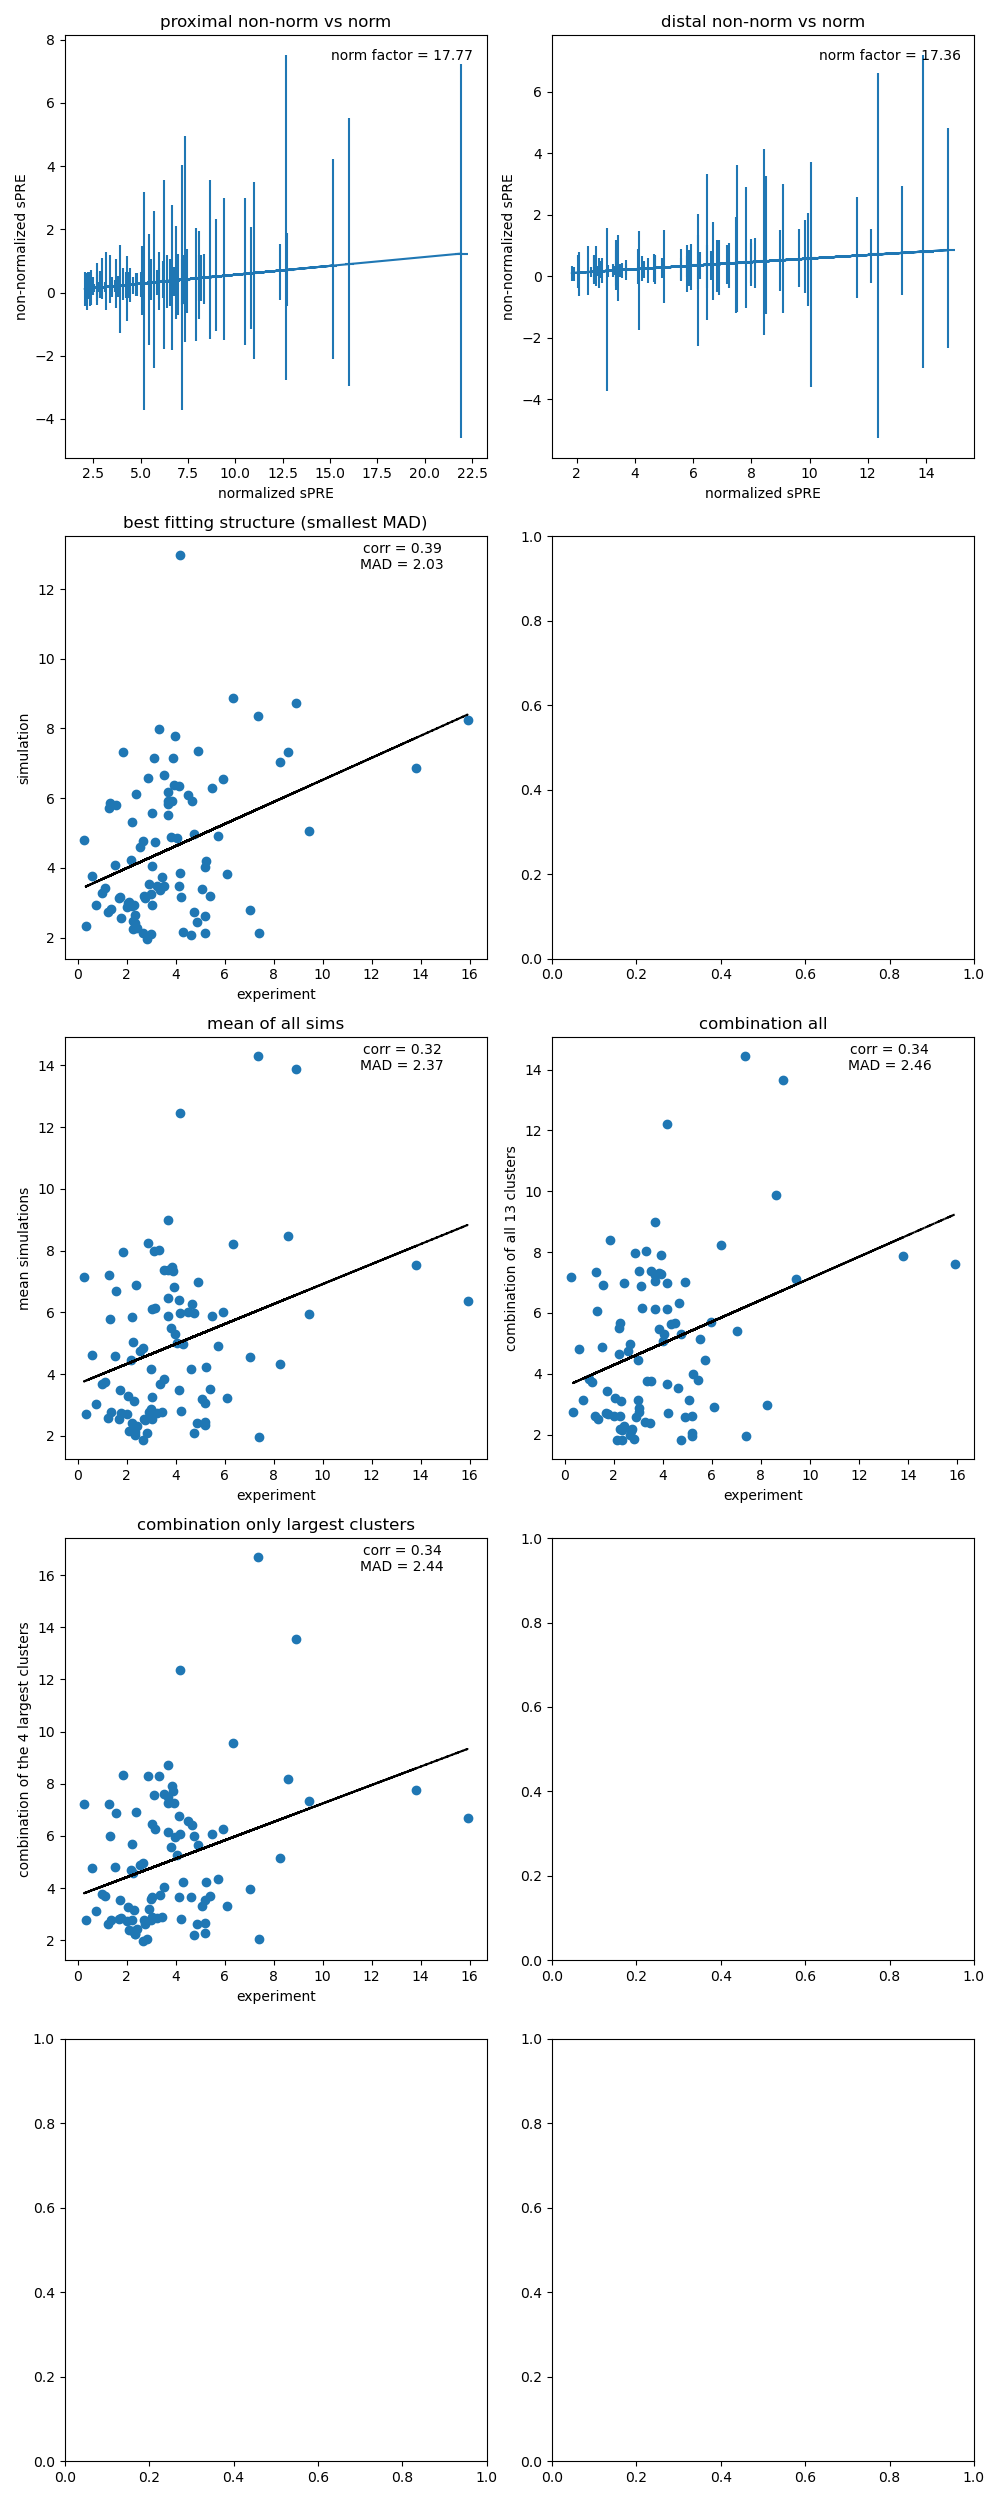

/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [68]:
from adjustText import adjust_text
from scipy.stats import pearsonr

UBQ_SITE = 'k6'

plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10, 25))

# for ax in axes.flatten():
#     ax.set(aspect='equal')


position = 'proximal'
x = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE]
x = x[('normalized sPRE', position)]
x.columns = x.columns.map(lambda _: ' '.join(_.split()[1:]))
y = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE]
y = y[('sPRE', position)]
axes[0, 0] = make_correlation(x, y, axes[0, 0], 'proximal non-norm vs norm',
                              'normalized sPRE', 'non-normalized sPRE',
                              False
                             )

position = 'distal'
x = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE]
x = x[('normalized sPRE', position)]
x.columns = x.columns.map(lambda _: ' '.join(_.split()[1:]))
y = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE]
y = y[('sPRE', position)]
axes[0, 1] = make_correlation(x, y, axes[0, 1], 'distal non-norm vs norm',
                              'normalized sPRE', 'non-normalized sPRE',
                              False
                             )

# structure with smallest MAD
idx = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE][[('data', '', 'mean_abs_diff')]].idxmin()
row = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE].loc[idx]
y = row['normalized sPRE']
y = y.droplevel(0, 'columns')
y.columns = y.columns.map(lambda _: _.replace('normalized ', ''))
y = y.iloc[0]
y.name = 'sim'
x = exp_values[UBQ_SITE]
x.name = 'exp'
axes[1, 0] = make_correlation(x, y, axes[1, 0], 'best fitting structure (smallest MAD)',
                              'experiment', 'simulation',
                              False,
                              exclusions=exclude_data[UBQ_SITE]
                             )


# mean of everything
mean = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE]['normalized sPRE'].mean()
mean = mean.droplevel(0)
mean.index = mean.index.map(lambda _: _.replace('normalized ', ''))
mean.name = 'sim'
assert mean.shape == (152, )
x = exp_values[UBQ_SITE]
x.name = 'exp'
axes[2, 0] = make_correlation(x, mean, axes[2, 0], 'mean of all sims',
                              'experiment', 'mean simulations',
                              False,
                              exclusions=exclude_data[UBQ_SITE]
                             )

# combination
combination = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE].groupby([('data', '', 'count_id')]).mean()
combination = combination['normalized sPRE']
combination = combination.droplevel(0, 'columns')
combination = combination.loc[range(len(combination) -1)]
combination = combination.reset_index(drop=True)
combination.columns = combination.columns.map(lambda _: _.replace('normalized ', ''))
combination = np.expand_dims(combination_factors[UBQ_SITE], 1) * combination
combination = combination.sum('rows')
combination.name = 'sim'
assert combination.shape == (152, )
x = exp_values[UBQ_SITE]
x.name = 'exp'
axes[2, 1] = make_correlation(x, combination, axes[2, 1], 'combination all',
                              'experiment', f'combination of all {len(combination_factors[UBQ_SITE])} clusters',
                              False,
                              exclusions=exclude_data[UBQ_SITE]
                             )

# combination only 3
combination = aa_df[aa_df[('data', '', 'ubq_site')] == UBQ_SITE].groupby([('data', '', 'count_id')]).mean()
combination = combination['normalized sPRE']
combination = combination.droplevel(0, 'columns')
combination = combination.loc[range(4)]
n_clusters = combination.shape[0]
combination = combination.reset_index(drop=True)
combination.columns = combination.columns.map(lambda _: _.replace('normalized ', ''))
combination = np.expand_dims(combination_factors_only_3[UBQ_SITE], 1) * combination
combination = combination.sum('rows')
combination.name = 'sim'
assert combination.shape == (152, )
x = exp_values[UBQ_SITE]
x.name = 'exp'
axes[3, 0] = make_correlation(x, combination, axes[3, 0], 'combination only largest clusters',
                              'experiment', f'combination of the {n_clusters} largest clusters',
                              False,
                              exclusions=exclude_data[UBQ_SITE]
                             )



# y = exp_values.loc[exp.values.index.str.contains(position), UBQ_SITE]

plt.tight_layout()
plt.show()

In [67]:
n_clusters

(4, 152)

In [750]:
exp_values['k6']

proximal MET1 sPRE    0.000000
proximal GLN2 sPRE    4.024789
                        ...   
distal GLY75 sPRE     0.000000
distal GLY76 sPRE     0.000000
Name: k6, Length: 152, dtype: float64

In [691]:
exp_values

,k6,k29,k33
proximal MET1 sPRE,0.000000,0.000000,0.000000
proximal GLN2 sPRE,4.024789,6.029261,5.775995
...,...,...,...
distal GLY75 sPRE,0.000000,0.000000,0.000000
distal GLY76 sPRE,0.000000,0.000000,0.000000


# fitness assessment

## Plot

<IPython.core.display.Javascript object>


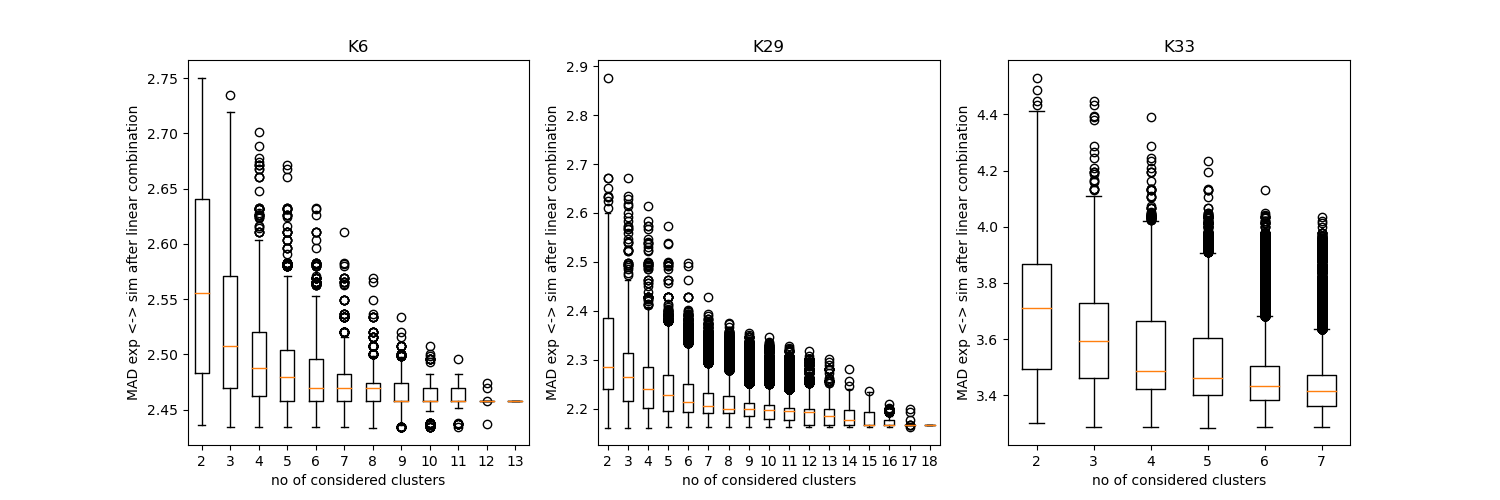

In [244]:
# del fitness_assessment
if 'fitness_assessment' not in globals():
    with open('/home/kevin/git/xplor_functions/xplor/data/quality_factors_with_fixed_normalization_pandas_native_parallel.json', 'r') as f:
        fitness_assessment = json.load(f)

plt.close('all')
fig, axes = plt.subplots(nrows=1, ncols=len(fitness_assessment),
                        figsize=(len(fitness_assessment) * 5, 5),
                        sharey=False)
        
for i, (ubq_site, values_for_ubq_site) in enumerate(fitness_assessment.items()):
    ax = axes[i]
    ax.set_title(ubq_site.upper())
    boxplot_data = [np.fromiter(v.values(), dtype=float) for v in values_for_ubq_site.values()]
    positions = [int(pos) for pos in values_for_ubq_site.keys()]
    ax.boxplot(x=boxplot_data, positions=positions)
    ax.set_xlabel("no of considered clusters")
    ax.set_ylabel("MAD exp <-> sim after linear combination")

plt.show()

## Find the lowest values

In [245]:
for i, (ubq_site, values_for_ubq_site) in enumerate(fitness_assessment.items()):
    ax = axes[i]
    ax.set_title(ubq_site.upper())
    mads = [np.fromiter(v.values(), dtype=float) for v in values_for_ubq_site.values()]
    cluster_ids = [np.array(list(v.keys())) for v in values_for_ubq_site.values()]
    
    min_mads = np.array([np.min(j) for j in mads])
    argmin_mads = np.array([np.argmin(j) for j in mads])
    
    for j, (min_, argmin_) in enumerate(zip(min_mads, argmin_mads)):
        identifier = cluster_ids[j][argmin_]
        no_considered = f"{j + 2} clusters"
        min_ = f"{min_}"
        print(f"K6 {no_considered:<12}: {min_}   {identifier}")
    
    combination_min = np.argmin(min_mads)
    cluster_count_min = argmin_mads[np.argmin(min_mads)]
    
    assert np.min(min_mads) == mads[combination_min][cluster_count_min]
    identifier = cluster_ids[combination_min][cluster_count_min]
    print(f"For the ubiquitination site {ubq_site}, the minimal mean absolute difference of {mads[combination_min][cluster_count_min]:.3f} "
          f"can be achieved by combining {combination_min + 2} clusters with the count ids: {identifier}.\n")
    

K6 2 clusters  : 2.4358223336087774   0, 2
K6 3 clusters  : 2.433889007683073   0, 2, 10
K6 4 clusters  : 2.4338889947146813   0, 2, 10, 11
K6 5 clusters  : 2.433888993296176   0, 1, 2, 10, 11
K6 6 clusters  : 2.4338889946339775   0, 1, 2, 3, 7, 10
K6 7 clusters  : 2.4338889943521242   0, 1, 2, 4, 7, 10, 11
K6 8 clusters  : 2.433888992686936   0, 1, 2, 3, 4, 7, 8, 10
K6 9 clusters  : 2.433888998680805   0, 1, 2, 3, 7, 8, 9, 10, 11
K6 10 clusters : 2.4338890010971426   0, 1, 2, 3, 4, 7, 8, 9, 10, 11
K6 11 clusters : 2.43388902193644   0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12
K6 12 clusters : 2.436787755890081   0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12
K6 13 clusters : 2.458190551249955   0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
For the ubiquitination site k6, the minimal mean absolute difference of 2.434 can be achieved by combining 8 clusters with the count ids: 0, 1, 2, 3, 4, 7, 8, 10.

K6 2 clusters  : 2.1611567745405287   8, 13
K6 3 clusters  : 2.1611567745405287   4, 8, 16
K6 4 clusters  : 

# Plot the first inclusion of count_id 0

<IPython.core.display.Javascript object>


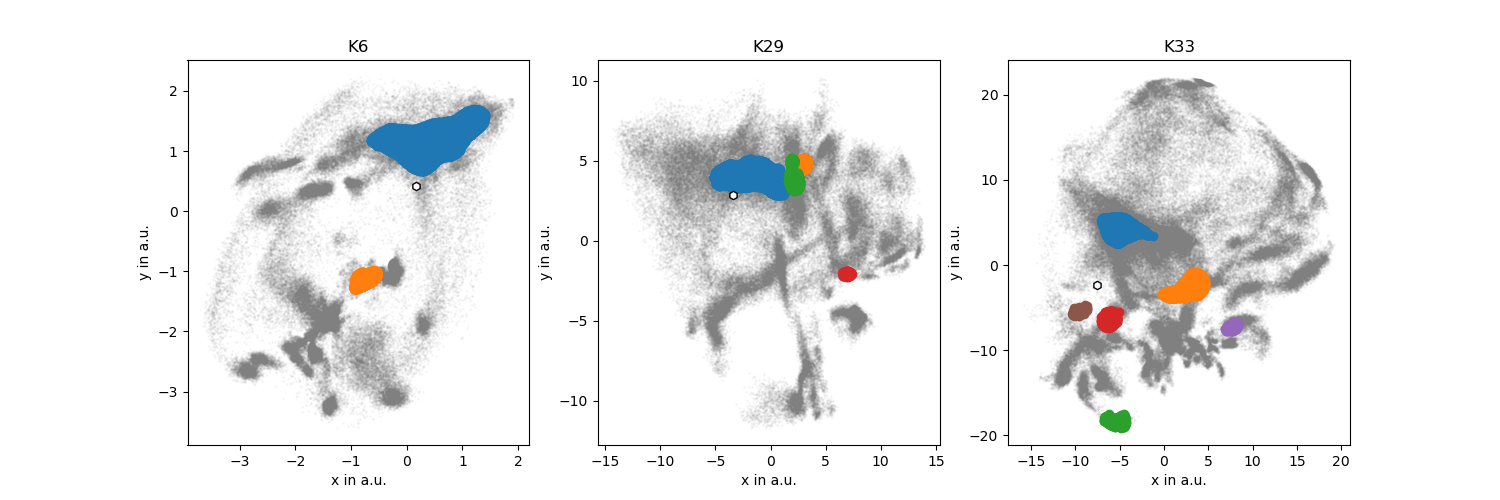

traj_file                                                  frame
/home/kevin/projects/molsim/diUbi_aa/K6_0/traj_nojump.xtc  6       -1
Name: (data, , count_id), dtype: int64
traj_file                                                     frame
/home/kevin/projects/molsim/diUbi_aa/K29_-80/traj_nojump.xtc  3196    -1
Name: (data, , count_id), dtype: int64
traj_file                                                                  frame
/home/andrejb/Research/SIMS/2017_11_16_2ub_NaCl_k33_02_05/traj_nojump.xtc  4823    -1
Name: (data, , count_id), dtype: int64


In [246]:
import ast

plt.close('all')
fig, axes = plt.subplots(nrows=1, ncols=len(fitness_assessment),
                        figsize=(len(fitness_assessment) * 5, 5),
                        sharey=False)
        
for i, (ubq_site, values_for_ubq_site) in enumerate(fitness_assessment.items()):
    ax = axes[i]
    ax.set_title(ubq_site.upper())
    
    mads = [np.fromiter(v.values(), dtype=float) for v in values_for_ubq_site.values()]
    cluster_ids = [np.array(list(v.keys())) for v in values_for_ubq_site.values()]
    
    min_mads = np.array([np.min(j) for j in mads])
    argmin_mads = np.array([np.argmin(j) for j in mads])
    
    boxplot_data = [np.fromiter(v.values(), dtype=float) for v in values_for_ubq_site.values()]
    positions = [int(pos) for pos in values_for_ubq_site.keys()]
    
    # ax.boxplot(x=boxplot_data, positions=positions)
    ax.set_xlabel("x in a.u.")
    ax.set_ylabel("y in a.u.")
    
    for j, (min_, argmin_) in enumerate(zip(min_mads, argmin_mads)):
        identifier = cluster_ids[j][argmin_]
        if '0' in identifier:
            identifier = list(ast.literal_eval(identifier))
            break
            
    ax.scatter(*aa_df[aa_df[('data', '', 'ubq_site')] == ubq_site]['Encodermap'].values.T, s=1, c='grey', alpha=0.05)
    
    for count_id in identifier:
        data = aa_df[(aa_df[('data', '', 'ubq_site')] == ubq_site) & (aa_df[('data', '', 'count_id')] == count_id)]['Encodermap'].values
        ax.scatter(*data.T)
        
    idx = aa_df[aa_df[('data', '', 'ubq_site')] == ubq_site][[('data', '', 'mean_abs_diff')]].idxmin()
    row = aa_df.loc[idx]
    print(row[('data', '', 'count_id')])
    
    ax.scatter(*row['Encodermap'].values.T, marker='h', edgecolors='k', color='w')

plt.show()

## Plot the plots for the optimizations

<IPython.core.display.Javascript object>


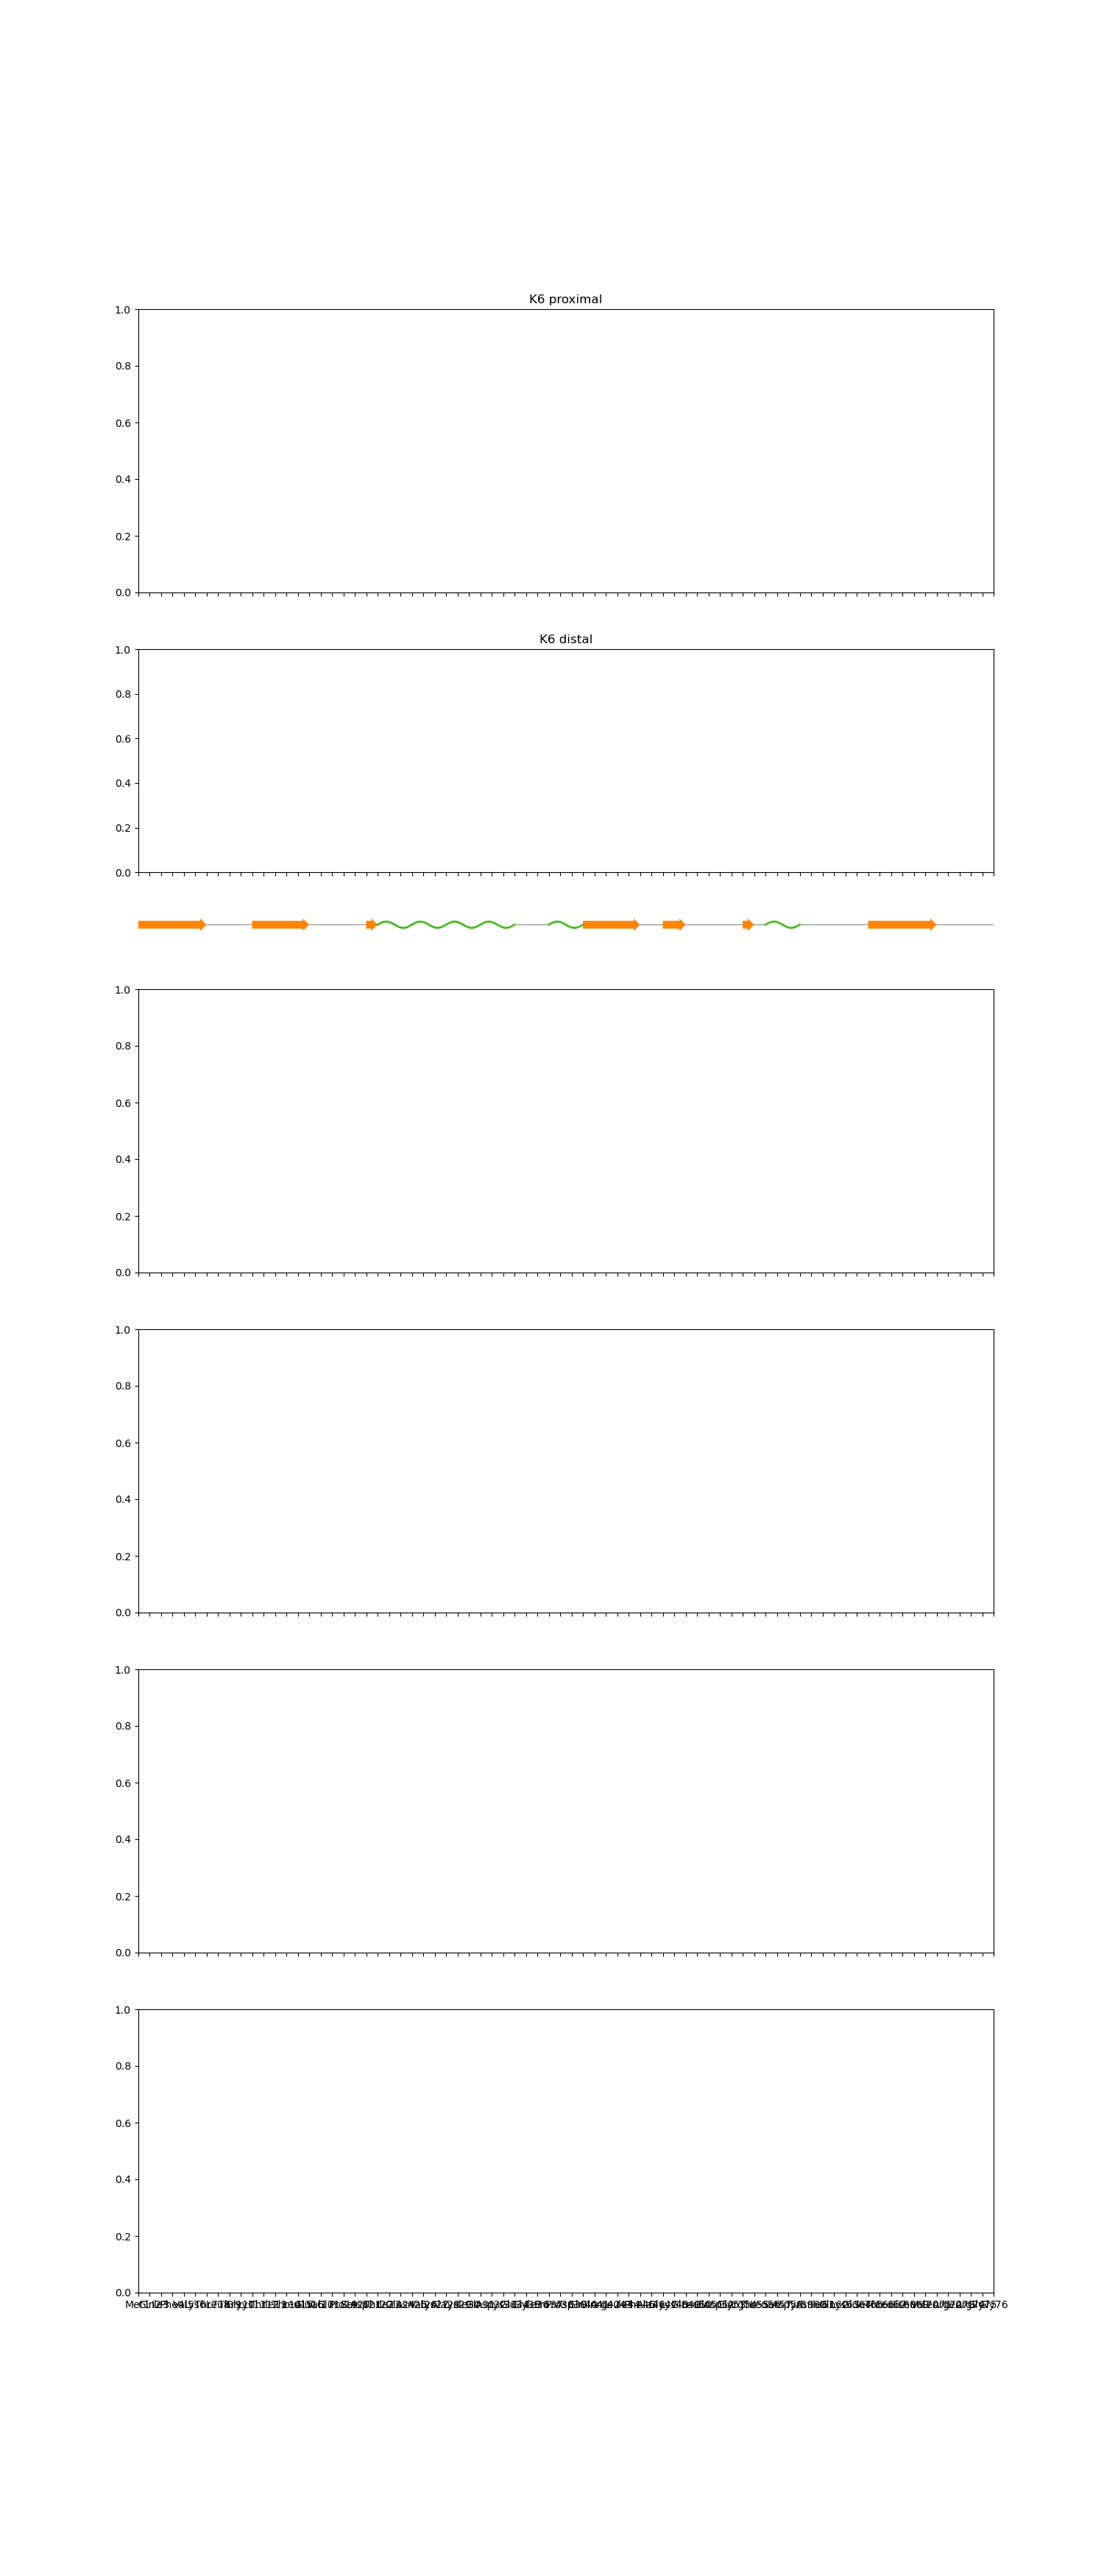

TypeError: string indices must be integers

In [255]:
from xplor.nmr_plot.nmr_plot import add_sequence_to_xaxis

plt.close('all')
fig, axes = plt.subplots(nrows=6, ncols=1,
                        figsize=(15, 35),
                        sharex=True)
        
iter_ = 0
for i, (ubq_site, values_for_ubq_site) in enumerate(fitness_assessment.items()):
    ax1 = axes[iter_]
    iter_ += 1
    ax2 = axes[iter_]
    iter_ += 1
    ax1.set_title(ubq_site.upper() + ' proximal')
    ax2.set_title(ubq_site.upper() + ' distal')
    
    ax2 = add_sequence_to_xaxis(ax2)
    
    (ax1, ax2) = xplor.nmr_plot.plot_line_data((ax1, ax2), exp_values, ubq_site)
    
plt.tight_layout()

# Redo the fitness assessment

In [133]:
%%writefile /home/kevin/git/xplor_functions/xplor/scripts/standalon_fitness_assessment.py

import pandas as pd
import numpy as np
import xplor
import os
import itertools
import json
from joblib import Parallel, delayed
from multiprocessing import cpu_count as mp_cpu_count
from typing import Callable
from scipy.optimize import minimize, NonlinearConstraint, Bounds, nnls

constraint = NonlinearConstraint(np.sum, 1., 1.)
bounds = Bounds(0, 1)

def get_objective_function(cluster_means: np.ndarray, observed_values: np.ndarray) -> Callable:
    def obj_fun(x: np.ndarray) -> float:
        return np.linalg.norm(np.sum(x * cluster_means, 1) - observed_values)
    return obj_fun

def make_linear_combination_from_clusters(aa_df, exp_values, exclude_data,
                                          ubq_site, parallel=False, cluster_nums=None):
    
    only_clusters_aa_df = aa_df.loc[(aa_df[('data', '', 'count_id')].isin(cluster_nums)) & (aa_df[('data', '', 'ubq_site')] == ubq_site)]
    means = only_clusters_aa_df.groupby([('data', '', 'ubq_site'), ('data', '', 'count_id')]).mean()['normalized sPRE']

    # reshape the cluster means
    means = means.droplevel(0, axis='columns').reset_index().drop(columns=[('data', '', 'count_id'), ('data', '', 'ubq_site')])

    # get observed values and exclusions
    exp = exp_values[ubq_site]
    if not exp.index.str.contains('normalized').all(None):
        exp.index = exp.index.map(lambda _: 'normalized ' + _)
    exclude = exclude_data[ubq_site]
    if not exclude.index.str.contains('normalized').all(None):
        exclude.index = exclude.index.map(lambda _: 'normalized ' + _)

    # remove exclusions
    try:
        exp = exp[~exclude]
        means = means.loc[:, ~exclude]
    except pd.core.indexing.IndexingError:
        print('exclude\n', exclude.index, '\n\n')
        print('exp\n', exp.index, '\n\n')
        print('means\n', means.columns, '\n\n')
        raise

    # initial guess
    initial_guess = nnls(means.T, exp)[0]

    # optimize
    res = minimize(get_objective_function(means.T, exp), initial_guess,
                   constraints=[constraint], bounds=bounds)
    
    # apply
    combination = (np.expand_dims(res.x, 1) * means).sum('rows')
    
    # get mad
    mad = (combination - exp).abs().mean()

    if parallel:
        return ', '.join([str(c) for c in cluster_nums]), mad
    else:
        return mad
    
# def parallel_fitness_assesment(cluster_nums):
#     solv = make_linear_combination_from_clusters(aa_df, exp_values, cluster_nums, ubq_site, exclude_data)
#     result = np.sum(solv * np.vstack([cluster_means[c] for c in cluster_nums]).T, 1)
#     diff = float(np.mean(np.abs(result[~fast_exch] - obs[~fast_exch])))
#     return ', '.join([str(c) for c in cluster_nums]), diff
    

def main(aa_df, exp_values, exclude_data,
         overwrite=False, soft_overwrite=True, parallel=True):
    
    if not parallel:
        json_savefile = '/home/kevin/git/xplor_functions/xplor/data/quality_factors_with_fixed_normalization_pandas_native.json'
    else:
        json_savefile = '/home/kevin/git/xplor_functions/xplor/data/quality_factors_with_fixed_normalization_pandas_native_parallel.json'

    quality_factor_means = {ubq_site: [] for ubq_site in UBQ_SITES}
    if not os.path.isfile(json_savefile) or (overwrite and not soft_overwrite):
        all_quality_factors = {ubq_site: {} for ubq_site in UBQ_SITES}
    else:
        with open(json_savefile, 'r') as f:
            all_quality_factors = json.load(f)
                
    for ubq_site in UBQ_SITES:
        obs = exp_values[ubq_site]

        df = aa_df[aa_df[('data', '', 'ubq_site')] == ubq_site]
        
        # calculate the per-cluster per-residue mean
        cluster_means = df.groupby([('data', '', 'count_id')]).mean()['normalized sPRE']
        cluster_means = cluster_means.droplevel([0], 'columns')
        cluster_means.index.name = 'count_id'
        cluster_means.columns = cluster_means.columns.map(lambda _: _.replace('normalized ', ''))

        # calculcate the per-cluster per-residue median
        allowed_clusters = np.unique(cluster_means.index)[1:]

        # check for soft overwrite
        if soft_overwrite:
            if len(all_quality_factors[ubq_site].keys()) == len(list(range(2, len(allowed_clusters) + 1))):
                print(f"All clusters already in the file for ubq_site {ubq_site}")
                continue
            else:
                print("Starting fitness assessment.")
                

        exclude = ~exclude_data[ubq_site]

        # n_clust = self.trajs[ubq_site].cluster_membership.max() + 1
        n_clust = len(allowed_clusters)
        print('checking clusters for ', ubq_site, allowed_clusters, n_clust)
        for no_of_considered_clusters in range(2, n_clust + 1):
            print(f'considering {no_of_considered_clusters} clusters')
            if soft_overwrite:
                if str(no_of_considered_clusters) in all_quality_factors[ubq_site]:
                    print(f"The combinations for {no_of_considered_clusters} for {ubq_site} "
                          f"are already in the dict. Continuing.")
                    continue
            combinations = itertools.combinations(allowed_clusters, no_of_considered_clusters)
            if str(no_of_considered_clusters) in all_quality_factors[ubq_site] and not overwrite:
                print(f"{no_of_considered_clusters} already in json")
                continue
            else:
                all_quality_factors[ubq_site][str(no_of_considered_clusters)] = {}
            if not parallel:
                for i, combination in enumerate(combinations):
                    combination = np.asarray(combination)
                    if i == 0:
                        print(f"First combination: {combination}")
                    # solv = scipy.optimize.nnls(np.vstack([cluster_means[c] for c in combination]).T[~fast_exchange], obs[~fast_exchange])[0]
                    diff = make_linear_combination_from_clusters(aa_df, exp_values, exclude_data,
                                                                 ubq_site, cluster_nums=combination)
                    all_quality_factors[ubq_site][str(no_of_considered_clusters)][', '.join([str(c) for c in combination])] = diff
                else:
                    print(f"Last combination: {combination}")
            else:
                # filter the combinations with non-aa clusters and cluster exclusions
                # not_aa_filter_func = lambda x: not np.any([np.isnan(cluster_means[c]) for c in x])
                # cluster_exclusions_filter_func = lambda x: not np.any([c in self.cluster_exclusions[ubq_site] for c in x])
                results = Parallel(n_jobs=mp_cpu_count() - 4)(delayed(make_linear_combination_from_clusters)(aa_df, exp_values, exclude_data, ubq_site, True, c) for c in combinations)

                # unpack results
                try:
                    results_dict = {k: v for k, v in results}
                except TypeError:
                    print(results)
                    raise
                all_quality_factors[ubq_site][str(no_of_considered_clusters)] = results_dict
            with open(json_savefile, 'w') as f:
                print("Dumping json")
                json.dump(all_quality_factors, f)
    

if __name__ == '__main__':
    UBQ_SITES = ['k6', 'k29', 'k33']
    
    # load the fast exchangers
    exp_values = xplor.functions.parse_input_files.get_observed_df(UBQ_SITES)
    fast_exchangers = xplor.functions.parse_input_files.get_fast_exchangers(UBQ_SITES)
    fast_exchangers.index = fast_exchangers.index.str.replace('fast_exchange', 'sPRE')
    exp_values = exp_values.filter(like='sPRE', axis=0)
    not_exp_values = exp_values == 0
    exclude_data = fast_exchangers | not_exp_values
    
    aa_df = pd.read_hdf('/home/kevin/git/xplor_functions/xplor/data/all_frames_sPRE_sim.h5', 'aa_df')
    main(aa_df, exp_values, exclude_data)

# main(aa_df, exp_values, exclude_data)

Overwriting /home/kevin/git/xplor_functions/xplor/scripts/standalon_fitness_assessment.py
